In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
import itertools
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
from yellowbrick.text import FreqDistVisualizer
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

In [ ]:
data = pd.read_csv('main_dataframe.csv')

In [ ]:
data.head(3)

,File Name,BIRADS Score,Content
0,308.txt,2,BİLATERAL MAMOGRAFİ İNCELEMESİ\nHer iki meme d...
1,405.txt,2,BİLATERAL MAMOGRAFİ İNCELEMESİ\nBilateral meme...
2,351.txt,2,BİLATERAL MAMOGRAFİ İNCELEMESİ\nHer iki meme y...


In [ ]:
data.rename(columns={'Content': 'content', 'BIRADS Score': 'label'}, inplace=True)

In [ ]:
data['label'].value_counts()

label
4    549
5    548
3    450
2    399
1     51
Name: count, dtype: int64

In [ ]:
print(data['content'].apply(lambda x: len(x.split(' '))).sum())

124534


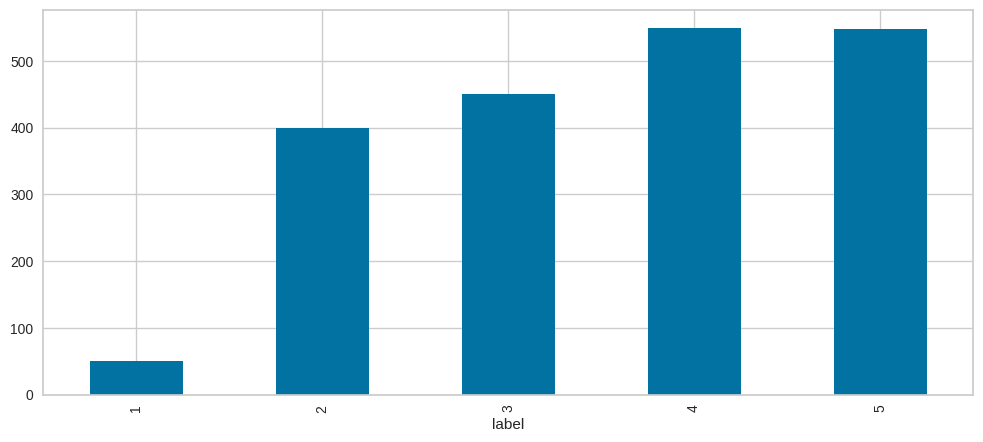

In [ ]:
fig = plt.figure(figsize=(12,5))
data.groupby('label').content.count().plot.bar(ylim=0)
plt.show();

In [ ]:
# Basic preprocessing
data['content'] = data['content'].str.lower().str.replace(r'[^\w\s]', '')


In [ ]:

turkish_stop_words = [
    'acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu', 'çok', 'çünkü',
    'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep', 'hepsi', 'her', 'hiç', 'için', 'ile',
    'ise', 'kez', 'ki', 'kim', 'mı', 'mu', 'mü', 'nasıl', 'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin',
    'niye', 'o', 'sanki', 'şey', 'siz', 'şu', 'tüm', 've', 'veya', 'ya', 'yani'
]



# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['content'], data['label'], test_size=0.125, stratify=data['label'], random_state=42)

# Initialize and fit-transform the TF-IDF vectorizer
tfidf = TfidfVectorizer(strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                        ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                        stop_words=turkish_stop_words)

tfidf.fit(list(train_texts) + list(val_texts))
X_train_tfidf = tfidf.transform(train_texts)
X_val_tfidf = tfidf.transform(val_texts)

# Initialize and train the Naive Bayes model
model = MultinomialNB()
model.fit(X_train_tfidf, train_labels)

# Make predictions
val_predictions = model.predict(X_val_tfidf)


target_names = ["BIRADS-1","BIRADS-2","BIRADS-3","BIRADS-4","BIRADS-5"]

# Print classification report
print(classification_report(val_labels, val_predictions, target_names=target_names))

# Print confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['birkac', 'birsey', 'cok', 'cunku', 'eger', 'hic', 'icin', 'nicin', 'sey', 'su', 'tum'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

    BIRADS-1       0.00      0.00      0.00         6
    BIRADS-2       0.70      0.76      0.73        50
    BIRADS-3       0.82      0.75      0.79        56
    BIRADS-4       0.84      0.83      0.83        69
    BIRADS-5       0.82      0.91      0.86        69

    accuracy                           0.80       250
   macro avg       0.64      0.65      0.64       250
weighted avg       0.78      0.80      0.79       250

Confusion Matrix:
[[ 0  4  1  0  1]
 [ 0 38  5  1  6]
 [ 0  2 42  7  5]
 [ 0  9  1 57  2]
 [ 0  1  2  3 63]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Function to predict the label of a new text
def predict_new_text(text):
    # Vectorize the text using the previously fitted TF-IDF vectorizer
    text_vectorized = tfidf.transform([text])
    # Predict the label using the trained model
    prediction = model.predict(text_vectorized)
    # Return the predicted label
    return target_names[prediction[0]]

# Test the function with a new text
new_text = "BİLATERAL MAMOGRAFİ İNCELEMESİ:	Cilt, cilt altı yağ dokusu ve meme başları doğaldır. Dens meme paterni izlenmektedir. Patolojik kalsifikasyon saptanmamıştır. Aksillalar doğaldır. Sağ meme iç alt kadranda irregüler şekilli  25 x 10 mm boyutunda silik sınırlı lezyon saptanmıştır."


predicted_label = predict_new_text(new_text)
print(f"Predicted Label for the new text: {predicted_label}")